# Experiments on Haar Features

In [16]:
import sys; sys.path.insert(0, '..')

import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc
from skimage.feature import draw_haar_like_feature, haar_like_feature_coord

from database.dataset import *
from mc_candidate_proposal.hough_mc import HoughCalcificationDetection
from feature_extraction.feature_extraction import CandidatesFeatureExtraction
import feature_extraction.haar_features.haar_modules as hm
# from general_utils.utils import get_an_example_array
from matplotlib.ticker import StrMethodFormatter, NullFormatter

# Only for fast GPU RF computation
# from cuml.ensemble import RandomForestClassifier as cuRFC

# Database initialization

In [2]:
db = INBreast_Dataset(
        return_lesions_mask=True,
        level='image',
        max_lesion_diam_mm=1.0,
        partitions=['train', 'validation'],  # This is not working as you want since last update, to do so include validation
        extract_patches=True,
        extract_patches_method='all',  # 'centered'
        patch_size=256,
        stride=256,
        min_breast_fraction_roi=0.5,
        normalize=None,
        n_jobs=-1,
)

# Candidate Proposals and Features Extractor

### Instantiate Candidate Proposals Detector and Features Extractor

In [3]:
# Candidate Proposals detector
hd = HoughCalcificationDetection()

# Feature extractor
haar_params = {
    'skimage': {
        'feature_type': None, 'feature_coord': None
    },
    'ours': {
        'horizontal_feature_types': [(hm.Feature3h3v, 3, 3)],
        'rotated_feature_types': None,
        'horizontal_feature_selection': None,
        'rotated_feature_selection': None,
    },
    'patch_size': 14
}
cfe  = CandidatesFeatureExtraction(patch_size=30, fos=False, haar_params=haar_params)

Extract features and save in disk

In [26]:
for idx in tqdm(range(len(db))):
    # Get image to process
    db_sample = db[idx]
    image = db_sample['img']
    image_id = db.df.iloc[idx].img_id
    image_mask = db_sample['lesion_mask']

    # Avoid reprocessing
    path = (Path.cwd().parent.parent / f'data/haar_features/{image_id}.fth')
    path.parent.mkdir(exist_ok=True, parents=True)
    if path.exists():
        continue
    else:
        # candidate detection
        candidates = hd.detect(image, image_id, load_processed_images=True, hough2=False)[0]

        # feature extraction
        X = cfe.extract_features(candidates, image, image_mask, fp2tp_sample=10)

        # Store in disk
        res = pd.DataFrame(data=X, columns=cfe.feature_names)
        res['img_id'] = image_id
        res.to_feather(path)

  0%|          | 0/154 [00:19<?, ?it/s]


# Classification

Generate an unified dataframe

In [9]:
# Generate an unified dataframe

# # Load features from disk
# fdf = []
# for idx in tqdm(range(len(db))):
#     # Get case
#     db_sample = db[idx]
#     image = db_sample['img']
#     image_id = db.df.iloc[idx].img_id
#     image_mask = db_sample['lesion_mask']

#     # Load data
#     path = (Path.cwd().parent.parent / f'data/haar_features/{image_id}.fth')
#     if path.exists():
#         fdf.append(pd.read_feather(path))
#     else:
#         print(f'warining: file {image_id}.fth does not exist')

# data = pd.concat(fdf).sample(frac=1)
# del fdf

## Store the complete data for future uses
# data.reset_index(drop=False).to_feather(Path.cwd().parent.parent / f'data/haar_features/all_train_img.fth')

100%|██████████| 154/154 [02:28<00:00,  1.03it/s]


Load all dataset

In [ ]:
# data = pd.read_feather(Path.cwd().parent.parent / f'data/haar_features/all_train_img.fth')
# data.set_index('index', inplace=True)

Fix the imbalance to 10 to 1 and store the dataset

In [19]:
# # Binarize labels 
# data['center_patch_mask_intersection'] = data.center_patch_mask_intersection>0

# # Sample
# np.random.seed(20)
# TPs = data.loc[data.center_patch_mask_intersection]
# n_TPs = len(TPs)
# sample_size = n_TPs * 10
# FPs = data.loc[~data.center_patch_mask_intersection].sample(sample_size, random_state=0, replace=False)

# # Rejoin
# data = pd.concat([TPs, FPs], axis=0).sample(frac=1)
# # Store
# data.reset_index(drop=False).to_feather(Path.cwd().parent.parent / f'data/haar_features/all_train_img_10to1.fth')

### Train only on our haar features

In [31]:
# Load the fixed unbalance dataset
data = pd.read_feather(Path.cwd().parent.parent / f'data/haar_features/all_train_img_10to1.fth')
data.set_index('index', inplace=True)

# Keep only our haar features
label_cols = ['candidate_coordinates', 'patch_coordinates', 'center_patch_mask_intersection', 'img_id']
data = data.loc[:, [i for i in data.columns if (i in label_cols) or ('rot_' in i) or ('hor_' in i)]]
data.reset_index(drop=False).to_feather(Path.cwd().parent.parent / f'data/haar_features/all_train_img_10to1_ours.fth')

In [52]:
aucs_test = []
aucs_train = []
best_10 = []
feat_importances = []
clfs = []

path = (Path.cwd().parent.parent / f'data/haar_models/')
path.mkdir(exist_ok=True, parents=True)

for k, test_img_id in tqdm(enumerate(utils.blockwise_retrieval(data.img_id.unique(), 7))):
    # Divide train and test based on cases (cross validation image wise)
    train_df = data[~data.img_id.isin(test_img_id)]
    test_df = data[data.img_id.isin(test_img_id)]

    # Generate features and labels datasets
    train_X = train_df.drop(columns=['patch_coordinates', 'candidate_coordinates', 'center_patch_mask_intersection', 'img_id'])
    train_y = (train_df.center_patch_mask_intersection).astype(int)
    test_X = test_df.drop(columns=['patch_coordinates', 'candidate_coordinates', 'center_patch_mask_intersection', 'img_id'])
    test_y = (test_df.center_patch_mask_intersection).astype(int)
    
    # Train a random forest classifier
    clf = RandomForestClassifier(n_estimators=1000, max_depth=None, n_jobs=-1, random_state=0)
    clf.fit(train_X, train_y)

    # Store the trained models
    
    filename = f'RF_our_{k}.sav'
    pickle.dump(clf, open(path / filename, 'wb'))
    
    # Asses performance
    test_y_predicted = clf.predict_proba(test_X)[:, 1]
    train_y_predicted = clf.predict_proba(train_X)[:, 1]
    auc_full_features_test = roc_auc_score(test_y, test_y_predicted)
    auc_full_features_train = roc_auc_score(train_y, train_y_predicted)
    aucs_test.append(auc_full_features_test)
    aucs_train.append(auc_full_features_train)
    
    # Store on memory the classifier and the feature importances
    clfs.append(clf)
    feat_importances.append(clf.feature_importances_)

# Store the auroc data to disk
auc_data = pd.DataFrame(aucs_test + aucs_train, columns=['auc'])
auc_data['set'] = ['val']*len(aucs_test) + ['train']*len(aucs_train)
auc_data.to_csv(path/'aucs_our_haar_21_runs.csv')
# Store the feature importances to disk
filename = f'feature_importances.sav'
pickle.dump(feat_importances, open(path/filename, 'wb'))

22it [1:40:39, 274.54s/it]


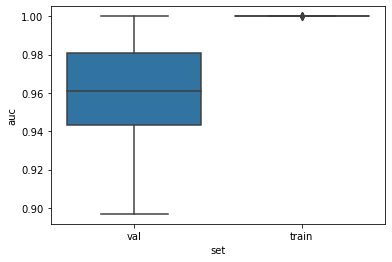

In [60]:
# Analize the AUC over the folds
sns.boxplot(data=auc_data, y='auc', x='set')
plt.show()

Evaluate the importance of features and their influence on the performance

In [15]:
# Load classifiers from disk
path = (Path.cwd().parent.parent / f'data/haar_models/')
our_features_clfs = []
for k in range(21):
    if k == 0:
        continue
    filename = f'RF_our_{k}.sav'
    with open(str(path / filename), 'rb') as f:
        cl = pickle.load(f)
    our_features_clfs.append(cl)

In [5]:
def sort_relevances(feat_importances):
    # Sort the feature importances for each classifier
    sorted_idxs = np.zeros((len(feat_importances), len(feat_importances[0])))
    for i in range(len(feat_importances)):
        sorted_idxs[i, :] = np.argsort(feat_importances[i])[::-1]

    # Strategy ONE
    # Going from most important to less, for each feature apply a voting strategy
    # At a certain position (let's say 2), see if across all the cross validation
    # fold some feature was repeated. If no feature is repeated sample one of them.
    # Always check if the most voted one, or the sample one has not already been 
    # included in the list, if so, keep on to the next position.
    # resulting_order = []
    # resulting_counts = []
    # for j in range(sorted_idxs.shape[1]):
    #     idxs, cnts = np.unique(sorted_idxs[:, j], return_counts=True)
    #     if j == 0:
    #         resulting_order.append(idxs[0])
    #         resulting_counts.append(cnts[0])
    #         continue
    #     for m in range(len(idxs)):
    #         if idxs[m] not in resulting_order:
    #             resulting_order.append(idxs[m])
    #             resulting_counts.append(cnts[m])
    #             break
    # # Get all the features which weren't selected (not sampled)
    # missing_idxs = np.asarray([i for i in range(len(feat_importances[0])) if i not in resulting_order])
    # # Since their order is not known just shuffle them
    # rng = np.random.default_rng(seed=0)
    # rng.shuffle(missing_idxs)

    # resulting_order.extend(missing_idxs.tolist())
    # resulting_counts.extend([1]*len(missing_idxs))

    # sorted_features_one = np.asarray(resulting_order)
    
    # sorted_features_one = pd.DataFrame(resulting_order, columns=['feature_idx'])
    # sorted_features_one['counts'] = resulting_counts
    # sorted_features_one.to_csv(path/'sorted_features_ours.csv')

    # Strategy TWO
    # Going from most important to less, for each feature apply a voting strategy
    # sort the unique features by votes, in the next feature importance level
    # repeat the process but add just the ones not previously added.
    resulting_order = []
    for j in range(sorted_idxs.shape[1]):
        idxs, cnts = np.unique(sorted_idxs[:, j], return_counts=True)
        resulting_order = resulting_order + [i for i in idxs if i not in resulting_order]
    # Just for sanity
    missing_idxs = np.asarray([i for i in range(len(feat_importances[0])) if i not in resulting_order])
    rng = np.random.default_rng(seed=0)
    rng.shuffle(missing_idxs)
    resulting_order = resulting_order + missing_idxs.tolist()
    sorted_features_two = np.asarray(resulting_order)
    return sorted_features_two

In [ ]:
# Load the feature importances for each classifier
feat_importances = []
for cl in our_features_clfs:
    feat_importances.append(cl.feature_importances_)

sorted_features_one, sorted_features_two = sort_relevances(feat_importances)

In [153]:
data = pd.read_feather(Path.cwd().parent.parent / f'data/haar_features/all_train_img_10to1_ours.fth')
data.set_index('index', inplace=True)

aucs_test_feat_sel_ours = {}
aucs_train_feat_sel_ours = {}
aupr_test_feat_sel_ours = {}
aupr_train_feat_sel_ours = {}
clfs_feat_sel_ours = {}

sorted_features = sorted_features_two

path = (Path.cwd().parent.parent / f'data/haar_models/')
path.mkdir(exist_ok=True, parents=True)

for i in [10, 5, 2]:
    clfs_feat_sel_ours[i] = []
    aucs_test_feat_sel_ours[i] = []
    aucs_train_feat_sel_ours[i] = []
    aupr_test_feat_sel_ours[i] = []
    aupr_train_feat_sel_ours[i] = []
    feature_selection = sorted_features[:i]

    data_ = data.iloc[:, feature_selection.astype(int).tolist() + [3321, 3322, 3323, 3324]]
    for k, test_img_id in tqdm(enumerate(utils.blockwise_retrieval(data.img_id.unique(), 30))):
        if k == 5:
            continue

        # Partition
        train_df = data_[~data_.img_id.isin(test_img_id)]
        test_df = data_[data_.img_id.isin(test_img_id)]

        # Feats and labels
        train_X = train_df.drop(columns=['patch_coordinates', 'candidate_coordinates', 'center_patch_mask_intersection', 'img_id'])
        train_y = (train_df.center_patch_mask_intersection).astype(int)
        test_X = test_df.drop(columns=['patch_coordinates', 'candidate_coordinates', 'center_patch_mask_intersection', 'img_id'])
        test_y = (test_df.center_patch_mask_intersection).astype(int)
        
        # Train a random forest classifier and assess its performance
        clf = RandomForestClassifier(n_estimators=1000, max_depth=None, n_jobs=-1, random_state=0)
        clf.fit(train_X,train_y)
        
        # Save the model to disk
        filename = f'RF_ours_cuml_{i}_{k}.sav'
        pickle.dump(clf, open(path / filename, 'wb'))
        
        # Performance
        test_y_predicted = clf.predict_proba(test_X)[:, 1]
        train_y_predicted = clf.predict_proba(train_X)[:, 1]
        
        # AUROC
        aucs_test_feat_sel_ours[i].append(roc_auc_score(test_y, test_y_predicted))
        aucs_train_feat_sel_ours[i].append(roc_auc_score(train_y, train_y_predicted))
        
        # PR
        pr, rc, th = precision_recall_curve(test_y, test_y_predicted)
        aupr_test_feat_sel_ours[i].append(auc(rc, pr))
        pr, rc, th = precision_recall_curve(train_y, train_y_predicted)
        aupr_train_feat_sel_ours[i].append(auc(rc, pr))

        # Store classifiers on memory
        clfs_feat_sel_ours[i].append(clf)
        print(aupr_test_feat_sel_ours[i])
        print(aucs_test_feat_sel_ours[i])

In [149]:
aupr_test_ours = pd.DataFrame.from_dict(aupr_test_feat_sel_ours)
aupr_test_ours.to_csv(path/'aupr_test_ours_sorted.csv')
cols = aupr_test_ours.columns
aupr_test_ours.reset_index(drop=False, inplace=True)
aupr_test_ours =pd.melt(aupr_test_ours, id_vars=['index'], value_vars=cols)

aucs_test_ours = pd.DataFrame.from_dict(aucs_test_feat_sel_ours)
aucs_test_ours.to_csv(path/'aucs_test_ours_sorted.csv')
cols = aucs_test_ours.columns
aucs_test_ours.reset_index(drop=False, inplace=True)
aucs_test_ours =pd.melt(aucs_test_ours, id_vars=['index'], value_vars=cols)

aupr_train_ours = pd.DataFrame.from_dict(aupr_train_feat_sel_ours)
aupr_train_ours.to_csv(path/'aupr_train_ours_sorted.csv')
cols = aupr_train_ours.columns
aupr_train_ours.reset_index(drop=False, inplace=True)
aupr_train_ours = pd.melt(aupr_train_ours, id_vars=['index'], value_vars=cols)

aucs_train_ours = pd.DataFrame.from_dict(aucs_train_feat_sel_ours)
aucs_train_ours.to_csv(path/'auc_train_ours_sorted.csv')
cols = aucs_train_ours.columns
aucs_train_ours.reset_index(drop=False, inplace=True)
aucs_train_ours =pd.melt(aucs_train_ours, id_vars=['index'], value_vars=cols)

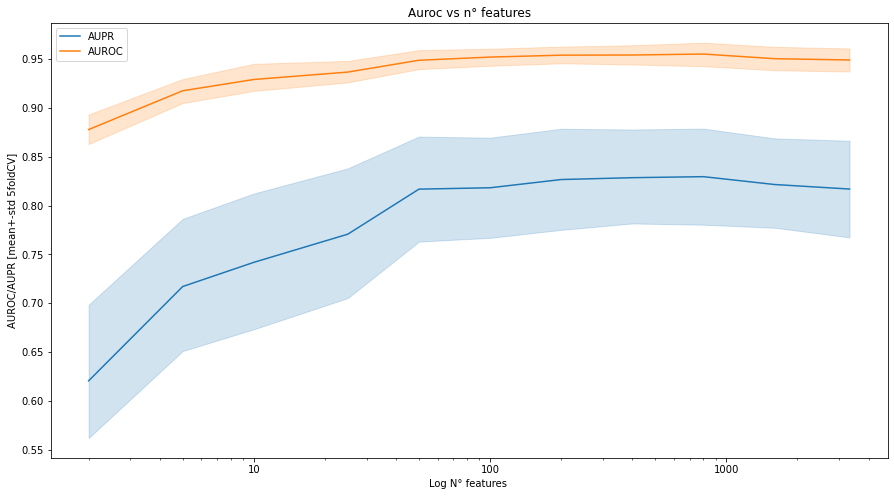

In [150]:
cmap = plt.get_cmap("tab10")
fig, ax = plt.subplots(1,1, figsize=(15,8))
ax.set_title('Auroc vs n° features')
sns.lineplot(x = aupr_test_ours.variable, y = aupr_test_ours.value, ax=ax, color=cmap(0), label='AUPR')
sns.lineplot(x = aucs_test_ours.variable, y = aucs_test_ours.value, ax=ax, color=cmap(1), label='AUROC')
ax.set_xscale('log')
ax.set_xlabel('Log N° features ')
ax.set_ylabel('AUROC/AUPR [mean+-std 5foldCV]')
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
ax.xaxis.set_minor_formatter(NullFormatter())
plt.legend()

## Train on all the haar features

In [11]:
data = pd.read_feather(Path.cwd().parent.parent / f'data/haar_features/all_train_img_10to1.fth')
data.set_index('index', inplace=True)

aucs_test_all = []
aucs_train_all = []
feat_importances_all = []
clfs_all = []

path = (Path.cwd().parent.parent / f'data/haar_models/')
path.mkdir(exist_ok=True, parents=True)

total = len(list(utils.blockwise_retrieval(data.img_id.unique(), 15)))
for k, test_img_id in tqdm(enumerate(utils.blockwise_retrieval(data.img_id.unique(), 15)), total=total):
    if (k == 11): # or (k == 0):
        continue

    # Partitions
    train_df = data[~data.img_id.isin(test_img_id)]
    test_df = data[data.img_id.isin(test_img_id)]

    # Features and labels
    train_X = train_df.drop(columns=['patch_coordinates', 'candidate_coordinates', 'center_patch_mask_intersection', 'img_id'])
    train_y = (train_df.center_patch_mask_intersection).astype(int)
    test_X = test_df.drop(columns=['patch_coordinates', 'candidate_coordinates', 'center_patch_mask_intersection', 'img_id'])
    test_y = (test_df.center_patch_mask_intersection).astype(int)
    
    # Train a random forest classifier and assess its performance
    clf = RandomForestClassifier(n_estimators=1000, max_depth=None, n_jobs=-1, random_state=0)
    clf.fit(train_X, train_y)

    # Save the model to disk
    filename = f'RF_all_{k}.sav'
    pickle.dump(clf, open(filename, 'wb'))
    
    # Performance
    test_y_predicted = clf.predict_proba(test_X)[:, 1]
    train_y_predicted = clf.predict_proba(train_X)[:, 1]
    
    auc_full_features_test = roc_auc_score(test_y, test_y_predicted)
    auc_full_features_train = roc_auc_score(train_y, train_y_predicted)
    aucs_test_all.append(auc_full_features_test)
    aucs_train_all.append(auc_full_features_train)
    
    print(f'train auc: {auc_full_features_train} - test auc: {auc_full_features_test}')
    
    # Save model in memory
    clfs_all.append(clf)
    
    feat_importances_all.append(clf.feature_importances_)

# # Store the auroc data to disk
# auc_data = pd.DataFrame(aucs_test_all + aucs_train_all, columns=['auc'])
# auc_data['set'] = ['val']*len(aucs_test_all) + ['train']*len(aucs_train_all)
# auc_data.to_csv(path/'aucs_all_haar_10_runs.csv')
# # Store the feature importances to disk
# filename = f'feature_importances_all_10runs.sav'
# pickle.dump(feat_importances, open(path/filename, 'wb'))

  0%|          | 0/11 [00:00<?, ?it/s]

train auc: 1.0 - test auc: 0.9706399437412097


 18%|█▊        | 2/11 [12:36<56:42, 378.06s/it]

train auc: 1.0 - test auc: 0.9506604770275254


 27%|██▋       | 3/11 [23:20<1:05:10, 488.83s/it]

train auc: 0.9999999999999999 - test auc: 0.9731130508321001


 36%|███▋      | 4/11 [36:20<1:09:43, 597.60s/it]

train auc: 1.0 - test auc: 0.9774302918762452


 45%|████▌     | 5/11 [49:05<1:05:36, 656.00s/it]

train auc: 1.0 - test auc: 0.9971463761579293


 55%|█████▍    | 6/11 [1:03:32<1:00:28, 725.78s/it]

train auc: 1.0 - test auc: 0.9742063492063492


 64%|██████▎   | 7/11 [1:18:38<52:15, 783.90s/it]  

train auc: 1.0 - test auc: 0.9863812154696132


 73%|███████▎  | 8/11 [1:33:52<41:14, 824.80s/it]

train auc: 1.0 - test auc: 0.9901312891003613


 82%|████████▏ | 9/11 [1:49:19<28:32, 856.45s/it]

train auc: 1.0 - test auc: 0.9770011947431302


 91%|█████████ | 10/11 [2:04:59<14:42, 882.30s/it]

train auc: 1.0 - test auc: 1.0


100%|██████████| 11/11 [2:46:37<00:00, 908.87s/it] 


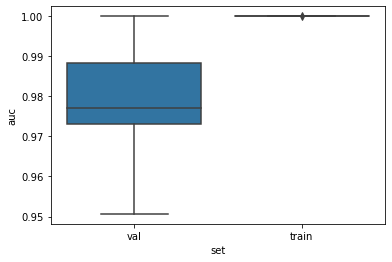

In [12]:
sns.boxplot(data=auc_data, y='auc', x='set')
plt.show()

In [6]:
# Load classifiers from disk
path = (Path.cwd().parent.parent / f'data/haar_models/')
our_features_clfs = []
for k in range(10):
    filename = f'RF_all_{k}.sav'
    with open(str(path / filename), 'rb') as f:
        cl = pickle.load(f)
    our_features_clfs.append(cl)

# Load the feature importances for each classifier
feat_importances = []
for cl in our_features_clfs:
    feat_importances.append(cl.feature_importances_)

sorted_features_two = sort_relevances(feat_importances)

Evaluate the influence of the number of features

In [19]:
data = pd.read_feather(Path.cwd().parent.parent / f'data/haar_features/all_train_img_10to1.fth')
data.set_index('index', inplace=True)

aucs_test_feat_sel_all = {}
aucs_train_feat_sel_all = {}
aupr_test_feat_sel_all = {}
aupr_train_feat_sel_all = {}
clfs_feat_sel_all = {}

sorted_features = sorted_features_two

path = (Path.cwd().parent.parent / f'data/haar_models/')
path.mkdir(exist_ok=True, parents=True)

for i in [len(sorted_features), 12800, 6400, 3200, 1600, 800, 400, 200, 100, 50, 25, 10, 5, 2]:
    clfs_feat_sel_all[i] = []
    aucs_test_feat_sel_all[i] = []
    aucs_train_feat_sel_all[i] = []
    aupr_test_feat_sel_all[i] = []
    aupr_train_feat_sel_all[i] = []
    feature_selection = sorted_features[:i]

    data_ = data.iloc[:, feature_selection.astype(int).tolist() + [22154, 22155, 22156, 22157]]
    for k, test_img_id in tqdm(enumerate(utils.blockwise_retrieval(data_.img_id.unique(), 30))):
        if k == 5:
            continue

        # Partition
        train_df = data_[~data_.img_id.isin(test_img_id)]
        test_df = data_[data_.img_id.isin(test_img_id)]

        # Feats and labels
        train_X = train_df.drop(columns=['patch_coordinates', 'candidate_coordinates', 'center_patch_mask_intersection', 'img_id'])
        train_y = (train_df.center_patch_mask_intersection).astype(int)
        test_X = test_df.drop(columns=['patch_coordinates', 'candidate_coordinates', 'center_patch_mask_intersection', 'img_id'])
        test_y = (test_df.center_patch_mask_intersection).astype(int)
        
        # Train a random forest classifier and assess its performance
        clf = RandomForestClassifier(n_estimators=1000, max_depth=None, n_jobs=-1, random_state=0)
        clf.fit(train_X,train_y)
        
        # Save the model to disk
        filename = f'RF_all_cuml_{i}_{k}.sav'
        pickle.dump(clf, open(path / filename, 'wb'))
        
        # Performance
        test_y_predicted = clf.predict_proba(test_X)[:, 1]
        train_y_predicted = clf.predict_proba(train_X)[:, 1]
        
        # AUROC
        aucs_test_feat_sel_all[i].append(roc_auc_score(test_y, test_y_predicted))
        aucs_train_feat_sel_all[i].append(roc_auc_score(train_y, train_y_predicted))
        
        # PR
        pr, rc, th = precision_recall_curve(test_y, test_y_predicted)
        aupr_test_feat_sel_all[i].append(auc(rc, pr))
        pr, rc, th = precision_recall_curve(train_y, train_y_predicted)
        aupr_train_feat_sel_all[i].append(auc(rc, pr))

        # Store classifiers on memory
        clfs_feat_sel_all[i].append(clf)

6it [1:01:35, 615.97s/it]
6it [45:23, 453.99s/it]
6it [33:32, 335.47s/it]
6it [21:29, 214.96s/it]
6it [14:41, 146.99s/it]
6it [09:49, 98.17s/it] 
6it [06:43, 67.18s/it]
6it [04:27, 44.57s/it]
6it [03:03, 30.64s/it]
6it [02:01, 20.27s/it]
6it [01:21, 13.62s/it]
6it [00:45,  7.65s/it]
6it [00:35,  5.86s/it]
6it [00:23,  3.96s/it]


In [21]:
aupr_test = pd.DataFrame.from_dict(aupr_test_feat_sel_all)
aupr_test.to_csv(path/'aupr_test_all_sorted.csv')
cols = aupr_test.columns
aupr_test.reset_index(drop=False, inplace=True)
aupr_test = pd.melt(aupr_test, id_vars=['index'], value_vars=cols)

aucs_test = pd.DataFrame.from_dict(aucs_test_feat_sel_all)
aucs_test.to_csv(path/'aucs_test_all_sorted.csv')
cols = aucs_test.columns
aucs_test.reset_index(drop=False, inplace=True)
aucs_test =pd.melt(aucs_test, id_vars=['index'], value_vars=cols)

aupr_train = pd.DataFrame.from_dict(aupr_train_feat_sel_all)
aupr_train.to_csv(path/'aupr_train_all_sorted.csv')
cols = aupr_train.columns
aupr_train.reset_index(drop=False, inplace=True)
aupr_train =pd.melt(aupr_train, id_vars=['index'], value_vars=cols)

aucs_train = pd.DataFrame.from_dict(aucs_train_feat_sel_all)
aucs_train.to_csv(path/'auc_train_all_sorted.csv')
cols = aucs_train.columns
aucs_train.reset_index(drop=False, inplace=True)
aucs_train =pd.melt(aucs_train, id_vars=['index'], value_vars=cols)

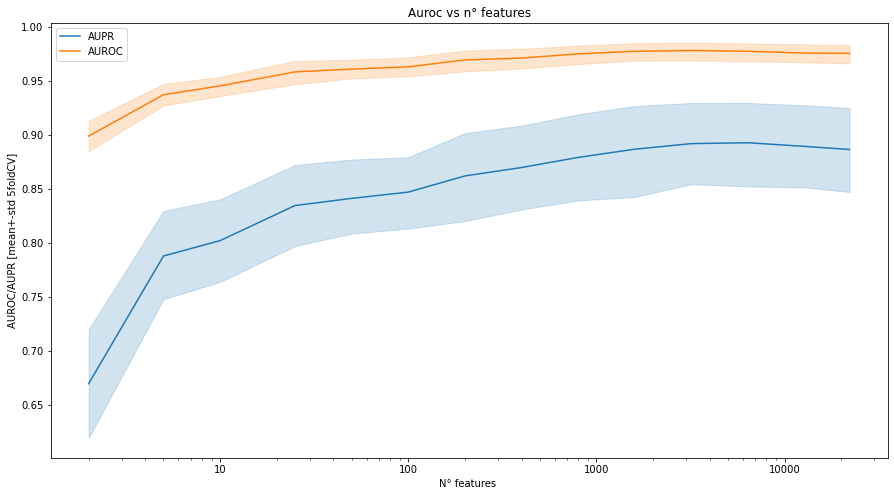

In [25]:
cmap = plt.get_cmap("tab10")
fig, ax = plt.subplots(1,1, figsize=(15,8))
ax.set_title('Auroc vs n° features')
sns.lineplot(x = aupr_test.variable, y = aupr_test.value, ax=ax, color=cmap(0), label='AUPR')
sns.lineplot(x = aucs_test.variable, y = aucs_test.value, ax=ax, color=cmap(1), label='AUROC')
ax.set_xscale('log')
ax.set_xlabel('N° features ')
ax.set_ylabel('AUROC/AUPR [mean+-std 5foldCV]')
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
ax.xaxis.set_minor_formatter(NullFormatter())
plt.legend()

# Final feature Selection and visualization

In [57]:
selected_feats = data.columns.values[sorted_features[:400].astype(int)]
skimage_feats_idxs = [int(i.lstrip('haar_')) for i in selected_feats if ('haar' in i) and ('rot' not in i) and ('hor' not in i)]
hor_feats_idxs = [int(i.lstrip('hor_haar_')) for i in selected_feats if ('haar' in i) and ('hor' in i)]
rot_feats_idxs = [int(i.lstrip('rot_haar_')) for i in selected_feats if ('haar' in i) and ('rot' in i)]

In [68]:
selection = {}
selection['skimage_haar_feature_coords_sel'] = cfe.skimage_haar_feature_coords[skimage_feats_idxs]
selection['skimage_haar_feature_types_sel'] = cfe.skimage_haar_feature_types[skimage_feats_idxs]
selection['hor_feats_selection'] = np.asarray(cfe.our_haar_feature_types_h)[hor_feats_idxs]
selection['rot_feats_selection'] = np.asarray(cfe.our_haar_feature_types_r)[rot_feats_idxs]

# Loading most discriminative haar features

In [4]:
# with open(path/'final_feat_selection.p', 'wb') as f:
#     pickle.dump(selection, f)
path = (Path.cwd().parent / f'feature_extraction/haar_features/')
with open(path/'final_feat_selection.p', 'rb') as f:
    selection = pickle.load(f)

In [5]:
# Feature extractor
haar_params = {
    'skimage': {
        'feature_type': None, 'feature_coord': None
    },
    'ours': {
        'horizontal_feature_types': [(hm.Feature3h3v, 3, 3)],
        'rotated_feature_types': None,
        'horizontal_feature_selection': None,
        'rotated_feature_selection': None,
    },
    'patch_size': 14
}
cfe_all  = CandidatesFeatureExtraction(patch_size=30, fos=False, haar_params=haar_params)

# ISTANTIATE the candidate Feature Extractor with the selected features.
haar_params = {
    'skimage': {
        'feature_type': selection['skimage_haar_feature_types_sel'],
        'feature_coord': selection['skimage_haar_feature_coords_sel']
    },
    'ours': {
        'horizontal_feature_selection': selection['hor_feats_selection'].tolist(),
        'rotated_feature_selection': selection['rot_feats_selection'].tolist(),
        'rotated_feature_types': None,
        'horizontal_feature_types': None
    },
    'patch_size': 14
}
cfe_sel  = CandidatesFeatureExtraction(patch_size=30, fos=False, haar_params=haar_params)

Time comparison

In [8]:
import time
db_sample = db[0]
image = db_sample['img']
image_id = db_sample['img_id']
image_mask = db_sample['lesion_mask']

# candidate detection
candidates = hd.detect(image, image_id, load_processed_images=True, hough2=False)[0]

# feature extraction
start = time.time()
X = cfe_all.extract_features(candidates, image, image_mask, fp2tp_sample=10)
time_all = time.time()- start

# feature extraction
start = time.time()
X = cfe_sel.extract_features(candidates, image, image_mask, fp2tp_sample=10)
time_sel = time.time()- start

print(f'time all: {time_all}    -    time selection: {time_sel}')
print(f'time all: {time_all/len(candidates)}    -    time selection: {time_sel/len(candidates)}')

time all: 10.810069799423218    -    time selection: 4.438370227813721
time all: 0.007197117043557402    -    time selection: 0.002954973520515127


visualize the features

In [7]:
images = utils.get_an_example_array(image, 14, candidates)

(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)


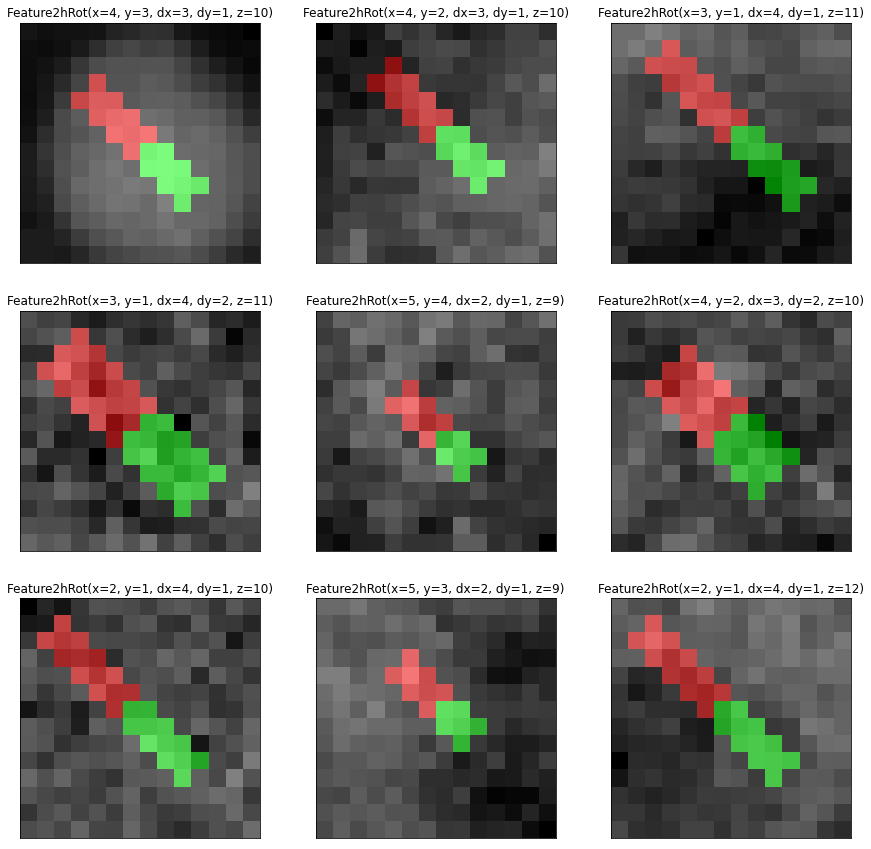

In [28]:
fig, axs = plt.subplots(3, 3, figsize=(15,15))
for ax, img, feat in zip(np.ravel(axs), images, selection['rot_feats_selection'][:9]):
    image = utils.draw_our_haar_like_features(img, feat)
    ax.imshow(image)
    ax.set_title(feat)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

In [35]:
# # Candidate Proposals detector
# hd = HoughCalcificationDetection()

# # Feature extractor
# haar_params = {
#     'skimage': {
#         'feature_type': selection['skimage_haar_feature_types_sel'],
#         'feature_coord': selection['skimage_haar_feature_coords_sel']
#     },
#     'ours': {
#         'horizontal_feature_selection': selection['hor_feats_selection'].tolist(),
#         'rotated_feature_selection': selection['rot_feats_selection'].tolist(),
#         'rotated_feature_types': None,
#         'horizontal_feature_types': None
#     },
#     'patch_size': 14
# }
# cfe  = CandidatesFeatureExtraction(patch_size=30, fos=False, haar_params=haar_params)

# fdf = []
# for idx in tqdm(range(len(db))):
#     # Get image to process
#     db_sample = db[idx]
#     image = db_sample['img']
#     image_id = db.df.iloc[idx].img_id
#     image_mask = db_sample['lesion_mask']

#     # candidate detection
#     candidates = hd.detect(image, image_id, load_processed_images=True, hough2=False)[0]

#     # feature extraction
#     X = cfe.extract_features(candidates, image, image_mask, fp2tp_sample=10)

#     # Store in disk
#     res = pd.DataFrame(data=X, columns=cfe.feature_names)
#     res['img_id'] = image_id
#     fdf.append(res)

data = pd.concat(fdf, ignore_index=True).sample(frac=1)
data['center_patch_mask_intersection'] = data['center_patch_mask_intersection']>0

aucs_test = []
aucs_train = []
aupr_test = []
aupr_train = []
aupr_curve_train = []
aupr_curve_test = []
auroc_curve_train = []
auroc_curve_test = []

total = len(list(utils.blockwise_retrieval(data.img_id.unique(), 15)))
for k, test_img_id in tqdm(enumerate(utils.blockwise_retrieval(data.img_id.unique(), 15)), total=total):
    if k != 0:
        continue
    # Partitions
    train_df = data[~data.img_id.isin(test_img_id)]
    test_df = data[data.img_id.isin(test_img_id)]

    # Features and labels
    train_X = train_df.drop(columns=['patch_coordinates', 'candidate_coordinates', 'center_patch_mask_intersection', 'img_id'])
    train_y = (train_df.center_patch_mask_intersection).astype(int)
    test_X = test_df.drop(columns=['patch_coordinates', 'candidate_coordinates', 'center_patch_mask_intersection', 'img_id'])
    test_y = (test_df.center_patch_mask_intersection).astype(int)
    
    # Train a random forest classifier and assess its performance
    clf = RandomForestClassifier(n_estimators=1000, max_depth=None, n_jobs=-1, random_state=0)
    clf.fit(train_X, train_y)

    # Performance
    test_y_predicted = clf.predict_proba(test_X)[:, 1]
    train_y_predicted = clf.predict_proba(train_X)[:, 1]
    
    auc_full_features_test = roc_auc_score(test_y, test_y_predicted)
    auc_full_features_train = roc_auc_score(train_y, train_y_predicted)
    aucs_test.append(auc_full_features_test)
    aucs_train.append(auc_full_features_train)
    fpr, tpr, th = roc_curve(test_y, test_y_predicted)
    auroc_curve_test.append([fpr, tpr])
    fpr, tpr, th = roc_curve(train_y, train_y_predicted)
    auroc_curve_train.append([fpr, tpr])
    
    pr, rc, th = precision_recall_curve(test_y, test_y_predicted)
    aupr_test.append(auc(rc, pr))
    aupr_curve_test.append([rc, pr])
    pr, rc, th = precision_recall_curve(train_y, train_y_predicted)
    aupr_train.append(auc(rc, pr))
    aupr_curve_train.append([rc, pr])
    print(f'train auc: {auc_full_features_train} - test auc: {auc_full_features_test}')

100%|██████████| 11/11 [01:57<00:00, 10.64s/it]

train auc: 0.9999999999999999 - test auc: 0.9724958489738574


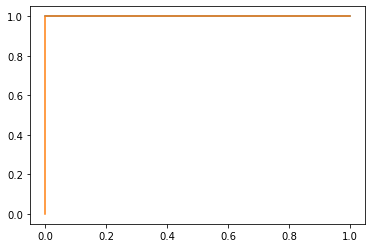

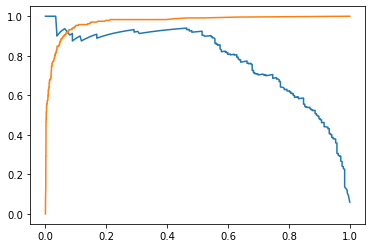

In [36]:
plt.plot(aupr_curve_train[0][0], aupr_curve_train[0][1])
plt.plot(auroc_curve_train[0][0], auroc_curve_train[0][1])

plt.figure()
plt.plot(aupr_curve_test[0][0], aupr_curve_test[0][1])
plt.plot(auroc_curve_test[0][0], auroc_curve_test[0][1])